# APAN 5210: Python for Data Analysis (Spring 2022)
## Anomaly detection using statistical learning for identifying possible heart attacks

**Prepared by**: Marcus Loke

## Table of contents
1. [Introduction](#intro)
2. [Import modules and data](#load)
3. [Explore data](#explore)
4. [Anomaly detection using seasonal ESD](#ad)
5. [Discussion](#discuss)

## 1. Introduction <a class="anchor" id="intro"></a>

This project seeks to use the anomaly detection (seasonal ESD) functions from the [GitHub repo](https://github.com/nachonavarro/seasonal-esd-anomaly-detection) by Nacho Navarro, which is the Python code of the technique that [Jordan Hochenbaum, Owen S. Vallis and Arun Kejariwa](https://arxiv.org/pdf/1704.07706.pdf) at Twitter Inc. have created. I will attempt to use the seasonal ESD function to flag out anomalies in the human heartrate, leading to better detection and timely prevention of a heart attack.

The sample heartrate data is taken from [Fitabase](https://www.fitabase.com/resources/knowledge-base/exporting-data/example-data-sets/), and it contains the 1-minute heartrate averages of a person from Oct 1, 2017 to Oct 8, 2017 (8 days).

To install the `sesd` module, use pip in the command prompt: `pip install sesd`.

## 2. Import modules and data <a class="anchor" id="load"></a>

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import sesd

In [2]:
# Load heartrate data
df = pd.read_csv('../data/heartrate_1min_7days.csv')
df.head()

,Time,Value
0,10/1/2017 12:00:00 AM,58
1,10/1/2017 12:01:00 AM,56
2,10/1/2017 12:02:00 AM,54
3,10/1/2017 12:03:00 AM,54
4,10/1/2017 12:04:00 AM,53


In [3]:
# Set the time column as a datetime format
df['Time'] = pd.to_datetime(df['Time'])

# Set the time column as the index
df.set_index('Time', inplace = True)
df.head()

,Value
Time,
2017-10-01 00:00:00,58
2017-10-01 00:01:00,56
2017-10-01 00:02:00,54
2017-10-01 00:03:00,54
2017-10-01 00:04:00,53


## 3. Explore data <a class="anchor" id="explore"></a>

Let's plot the heartrates across date/time to better understand the peaks and troughs throughout the day. As you can see, the heartrate usually spikes in the midday/afternoon and evenings. This could be due to increased body movements when the person goes for lunch or when the person returns home.

Text(0.5, 0, 'Date/time')

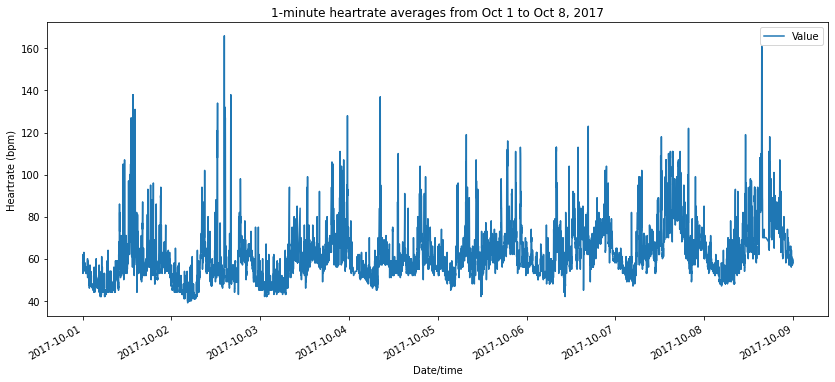

In [4]:
# Plot heartrate
df.plot(figsize = (14,6))
plt.title('1-minute heartrate averages from Oct 1 to Oct 8, 2017')
plt.ylabel('Heartrate (bpm)')
plt.xlabel('Date/time')

For the purposes of testing and demonstrating the use of the seasonal ESD algorithm to detect anomalies, I will insert artificial anomalies during some parts of the day to simulate a heart attack. For simplicity, I will insert increased heart rates in the wee hours of the morning (when the person is supposedly sleeping), as shown in red below.

In [5]:
# Insert artificial anomalies (increased heartrates) from 3:31am to 3:33am on Oct 5
df.iloc[5900,:] = 140
df.iloc[5901,:] = 150
df.iloc[5902,:] = 155

Text(0.5, 0, 'Date/time')

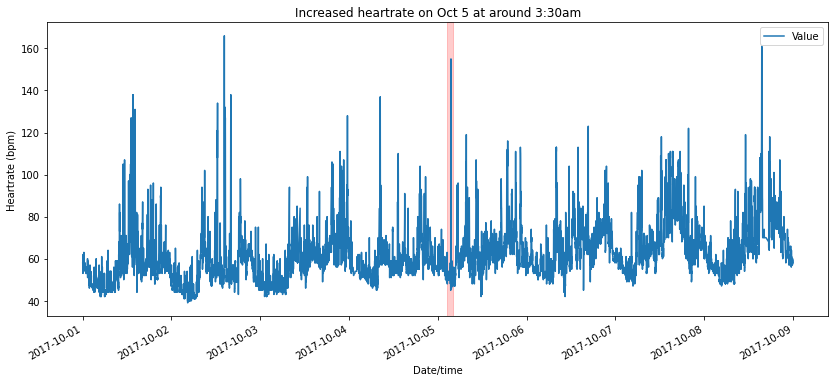

In [6]:
# Plot heartrate with artificial anomalies
df.plot(figsize = (14,6))
plt.axvspan(*mdates.datestr2num(['10/5/2017 2:30', '10/5/2017 4:10']), color='red', alpha=0.2)
plt.title('Increased heartrate on Oct 5 at around 3:30am')
plt.ylabel('Heartrate (bpm)')
plt.xlabel('Date/time')

## 4. Anomaly detection using seasonal ESD <a class="anchor" id="ad"></a>

In this section, we will attempt to use the seasonal ESD function to automatically detect for us the increased heartrates that were artificially inserted on Oct 5 at around 3:30am. Note that we will have to convert `df` into a numpy array because the `seasonal_esd()` function takes in either a numpy array or list as its input only. See the [documentation](https://github.com/nachonavarro/seasonal-esd-anomaly-detection/blob/master/sesd.py) for more information.

The function parameters are explained as follows:
+ The `periodicity` param is the number of points for a season and is set to 1440 because there are 1440 minutes in a day. 
+ The `hybrid` param determines the type of Z-score to use. For conventional Z-score computation (`hybrid=False`), the mean and sd is are used, whereas the hybrid Z-score (`hybrid=True`) uses the median and median absolute deviation (MAD) to detect anomalies. If there are many anomalies in the data, the mean and sd in conventional Z-score can be inflated, resulting in true anomalies being mis-labeled as not anomalous (leading to high FN). We use hybrid Z-score because we anticipate the data to have high percentage of anomalies.
+ The `max_anomalies` param determines how many times the Grubbs' Test will be applied to the time series data. This is the test statistic that is applied to each anomaly and the null hypothesis of no outliers is rejected at the significance level.

In [7]:
# Convert df to numpy array
df_ts = df.stack().to_numpy()

In [8]:
# Run seasonal ESD function
outliers_indices = sesd.seasonal_esd(df_ts, periodicity = 1440, hybrid = True, max_anomalies = 5)
for idx in outliers_indices:
    print(f'Anomalous heartrate: {df.iloc[idx,:]}')

Anomalous heartrate: Value    166
Name: 2017-10-02 14:17:00, dtype: int64
Anomalous heartrate: Value    75
Name: 2017-10-01 14:05:00, dtype: int64
Anomalous heartrate: Value    155
Name: 2017-10-05 03:33:00, dtype: int64
Anomalous heartrate: Value    150
Name: 2017-10-05 03:32:00, dtype: int64
Anomalous heartrate: Value    140
Name: 2017-10-05 03:31:00, dtype: int64


Based on the list of outliers that were generated from the `seasonal_esd()` function, we will plot it for easy viewing. The red sections are flagged by the algorithm as anomalous.

Text(0.5, 0, 'Date/time')

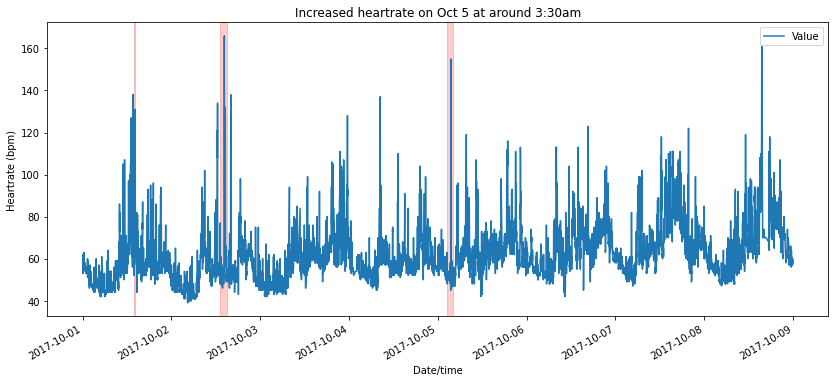

In [9]:
# Plot heartrate
df.plot(figsize = (14,6))
plt.axvspan(*mdates.datestr2num(['10/5/2017 2:30', '10/5/2017 4:10']), color='red', alpha=0.2)
plt.axvspan(*mdates.datestr2num(['10/2/2017 13:00', '10/2/2017 15:00']), color='red', alpha=0.2)
plt.axvspan(*mdates.datestr2num(['10/1/2017 14:00', '10/1/2017 14:10']), color='red', alpha=0.2)
plt.title('Increased heartrate on Oct 5 at around 3:30am')
plt.ylabel('Heartrate (bpm)')
plt.xlabel('Date/time')

## 5. Discussion <a class="anchor" id="discuss"></a>

+ The results indicate that the anomaly detection algorithm has successfully flagged the three artificial anomalies inserted at around 3:30am on Oct 5 (heartrates of 140, 150 and 155 bpm respectively).


+ An anomalous heartrate of 166 bpm was also detected on Oct 2, 2:17pm, which makes sense because the heartrate was at its peak over this 8-day period and there were no other days (at the same time period) where the heartrate was this extreme.


+ Interestingly, an anomalous heartrate of 75 bpm was flagged on Oct 1, 2:05pm, which is pretty strange because the heartrate does not seem that high. A possible explanation could be that this is a local anomaly that would otherwise be masked by seasonal data. We will need to investigate further to understand why this was flagged as an anomaly.